/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
[GRAPHCUT] step1 elapsed: 1.1256844997406006
[GRAPHCUT] step2 elapsed: 0.012993097305297852
[GRAPHCUT] step3 elapsed: 0.00706028938293457
[GRAPHCUT] step4 elapsed: 23.903693675994873
elapsed 25.05176830291748


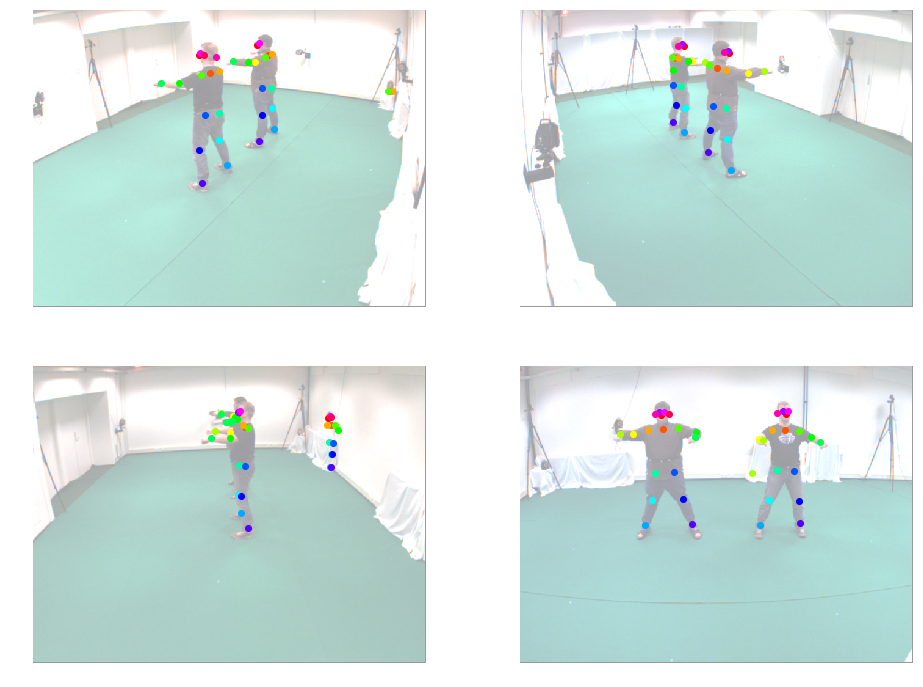

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.insert(0,'../../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../../')
import mvpose.data.transform as tfm
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.pose_estimation.heatmaps as mvhm
from mvpose.candidates import peaks as mvpeaks
import mvpose.pose_estimation.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_MAP_IDX
from mvpose.algorithm import graphcut
from cselect import color as cs




root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()


from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

# interesting frames: [340, 215, 250]
FRAME = 0

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
with_gpu = False

if with_gpu:
    _start = time()
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
    _end = time(); print('elapsed:', _end - _start)
else:
    hm_file = '/tmp/heatmaps' + str(FRAME) + '.npy'
    paf_file = '/tmp/pafs' + str(FRAME) + '.npy'
    
    if isfile(hm_file) and isfile(paf_file):
        heatmaps = np.load(hm_file)
        pafs = np.load(paf_file)
    else:
        heatmaps = []; pafs = []
        for im in Im:
            _start = time()
            hm, paf = pe.predict_pafs_and_heatmaps(im)
            heatmaps.append(np.squeeze(hm))
            pafs.append(np.squeeze(paf))
            _end = time()
            print('elapsed:', _end - _start)
        heatmaps = np.array(heatmaps)
        pafs = np.array(pafs)
        np.save(hm_file, heatmaps)
        np.save(paf_file, pafs)
        
import mvpose.plot.limbs as pltlimbs

colors = cs.lincolor(19)/255

r = 200
_start = time()
Gr = graphcut.GraphCutSolver(heatmaps, pafs, Calib, r, debug=True)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2,2,idx+1)
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d[idx].n_joints):
        for x,y,score in Gr.peaks2d[idx][jid]:
            ax.scatter(x,y, color=colors[jid])
    
plt.show()

## Undistored peaks

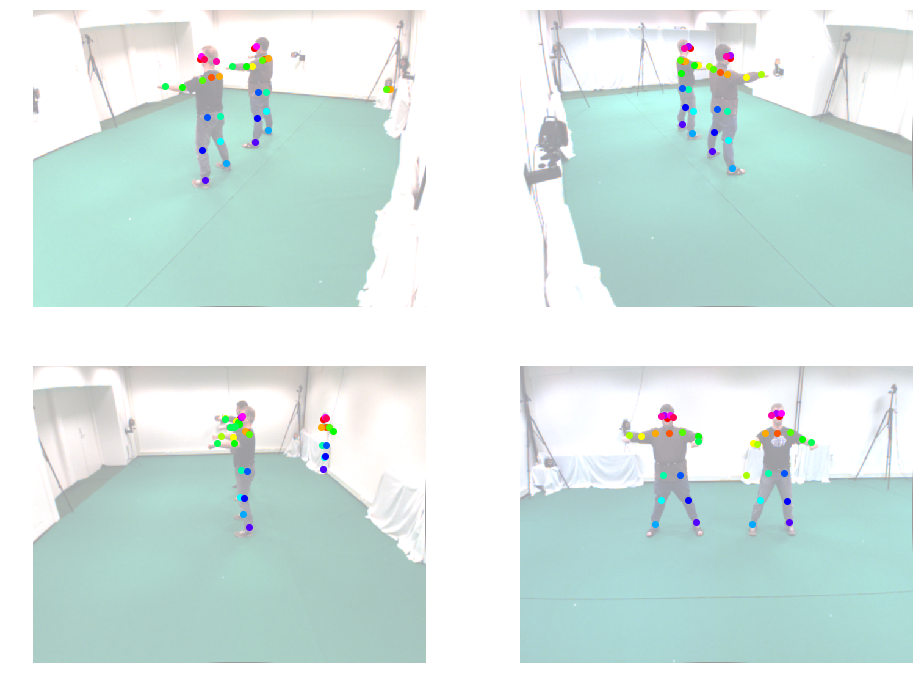

In [2]:
fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2,2,idx+1)
    
    mapx, mapy = Gr.undistort_maps[idx]
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d_undistorted[idx].n_joints):
        for x,y,score in Gr.peaks2d_undistorted[idx][jid]:
            ax.scatter(x,y, color=colors[jid])
            
plt.show()

## Re-distort 
This is needed for mapping the 3d points onto the part affinity fields

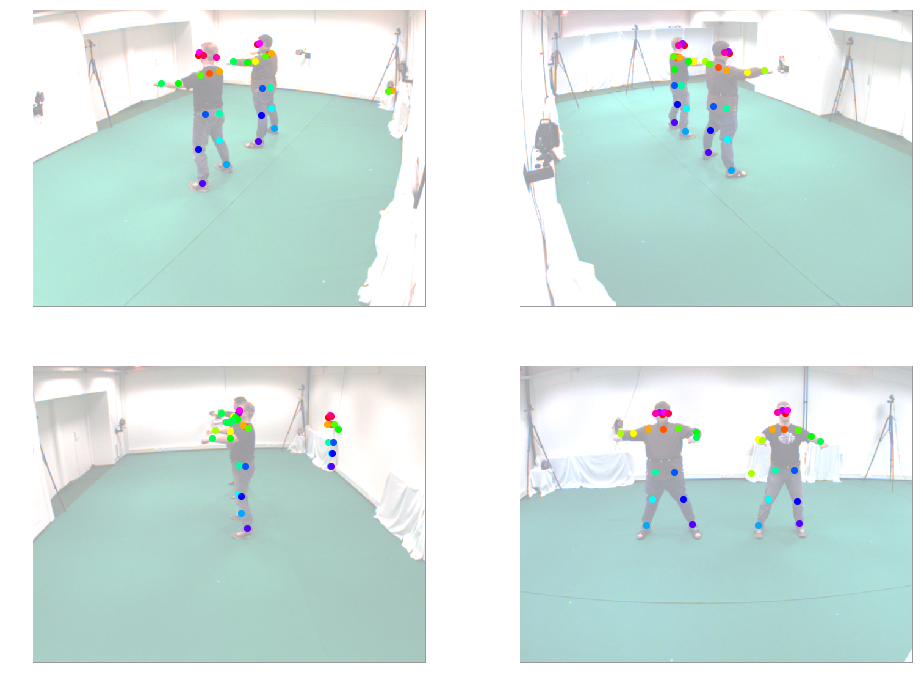

In [3]:
fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2,2,idx+1)
    
    mapx, mapy = Gr.undistort_maps[idx]
    
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d_undistorted[idx].n_joints):
        points = Gr.peaks2d_undistorted[idx][jid]
        points_dist = gm.distort_points(points, mapx, mapy)
        for x,y,score in points_dist:
            ax.scatter(x,y, color=colors[jid])
            
plt.show()

## Show all 3d peaks with weights

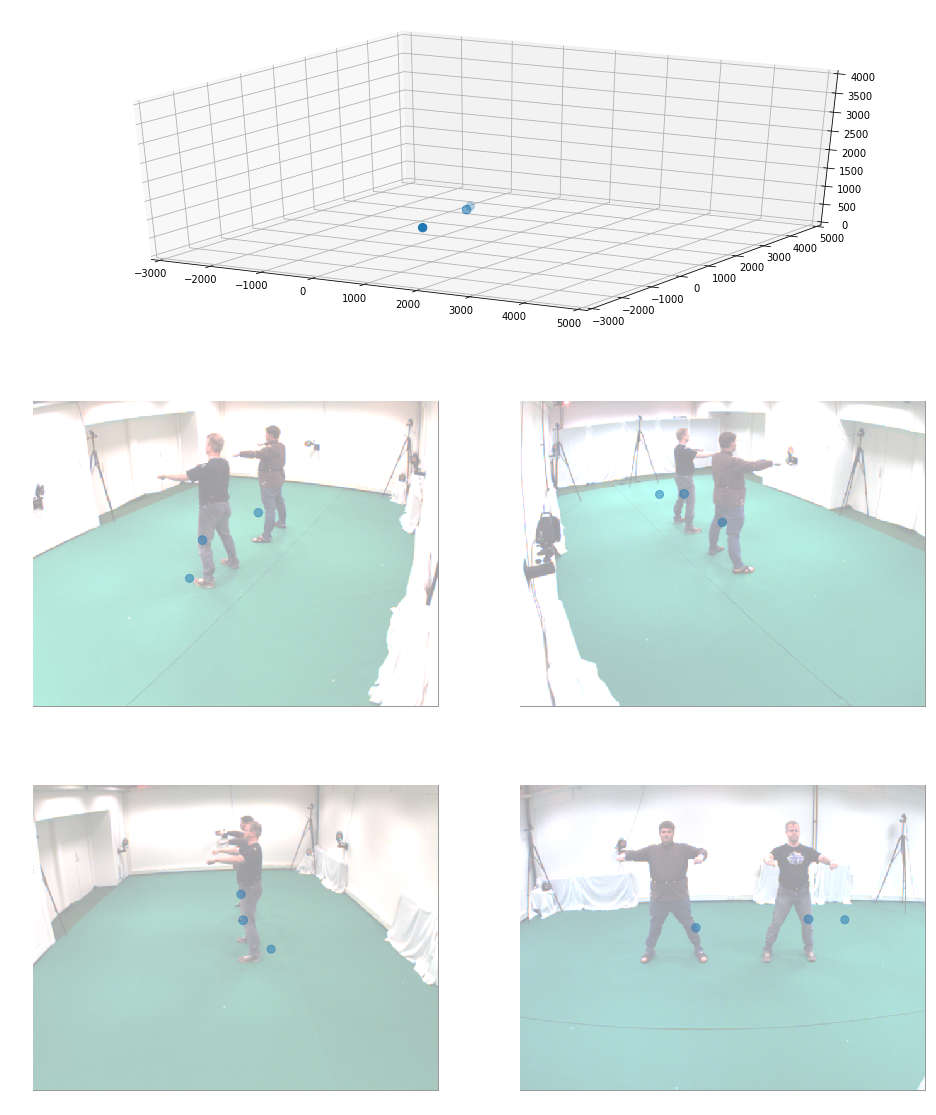

In [4]:
JOINT_ID = 12
Noses = Gr.peaks3d_weighted[JOINT_ID]

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(311, projection='3d')
ax.set_xlim([-3000, 5000])
ax.set_ylim([-3000, 5000])
ax.set_zlim([0, 4000])

X = Noses[:,0]
Y = Noses[:,1]
Z = Noses[:,2]
W = Noses[:,3] * Noses[:,4]

ax.scatter(X,Y,Z, s=W*100)

# --- reproject ---
Pts3d = Noses[:,0:3]
Pts3d = Pts3d.astype('float64')

for idx, cam in enumerate(Gr.Calib_undistorted):
    ax = fig.add_subplot(3,2,3+idx)
    ax.axis('off')
    
    im = Im[idx]
    
    ax.imshow(im, alpha=0.4)
    
    Noses2d = Gr.candidates2d[idx][JOINT_ID]
    #Noses2d = Gr.candidates2d_undistorted[idx][0]
    
    x = Noses2d[:,0]
    y = Noses2d[:,1]
    W = Noses2d[:,2] *  Noses2d[:,3]
    ax.scatter(x,y, alpha=0.5, s=W*100)
    
    
plt.show()

elapsed 0.10235881805419922


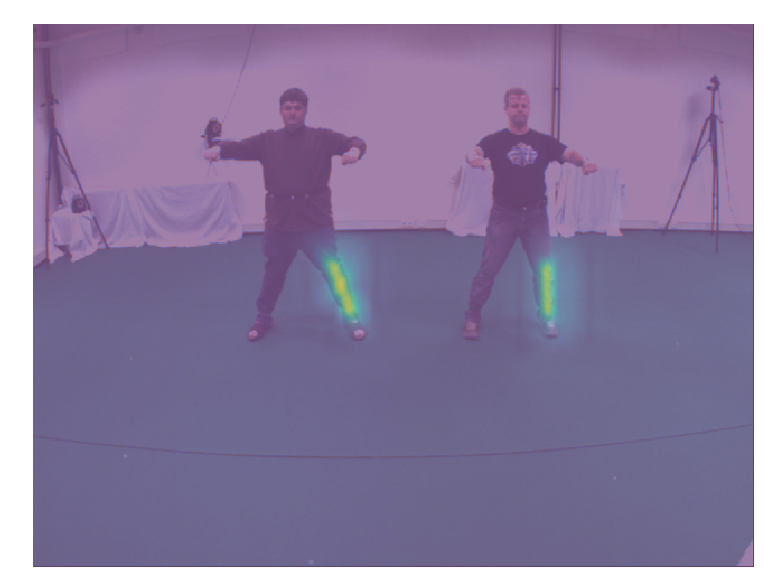

min: 2.1072178944730775e-06
max: 1.2406433026180117


In [5]:
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH, DEFAULT_MAP_IDX
from mvpose.plot.limbs import draw_vector_field

assert len(DEFAULT_MAP_IDX) == len(DEFAULT_LIMB_SEQ)

LIMB_ID = 11
a,b = DEFAULT_MAP_IDX[LIMB_ID]

U = pafs[3,:,:,a]
V = pafs[3,:,:,b]

_start = time()
Vec = draw_vector_field(U, V)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.imshow(Im[3], alpha=0.5)
ax.matshow(Vec, alpha=0.5)
ax.axis('off')
plt.show()


print('min:', np.min(Vec))
print('max:', np.max(Vec))

In [6]:
#comb(4,2)

part 1 elapsed: 0.00018906593322753906
(1, 1)
elapsed 0.11324596405029297
part 1 elapsed: 0.00017905235290527344
(1, 1)
elapsed 0.11412882804870605
part 1 elapsed: 0.00017642974853515625
(1, 1)
elapsed 0.11358165740966797
part 1 elapsed: 0.0001766681671142578
(1, 1)
elapsed 0.11419200897216797


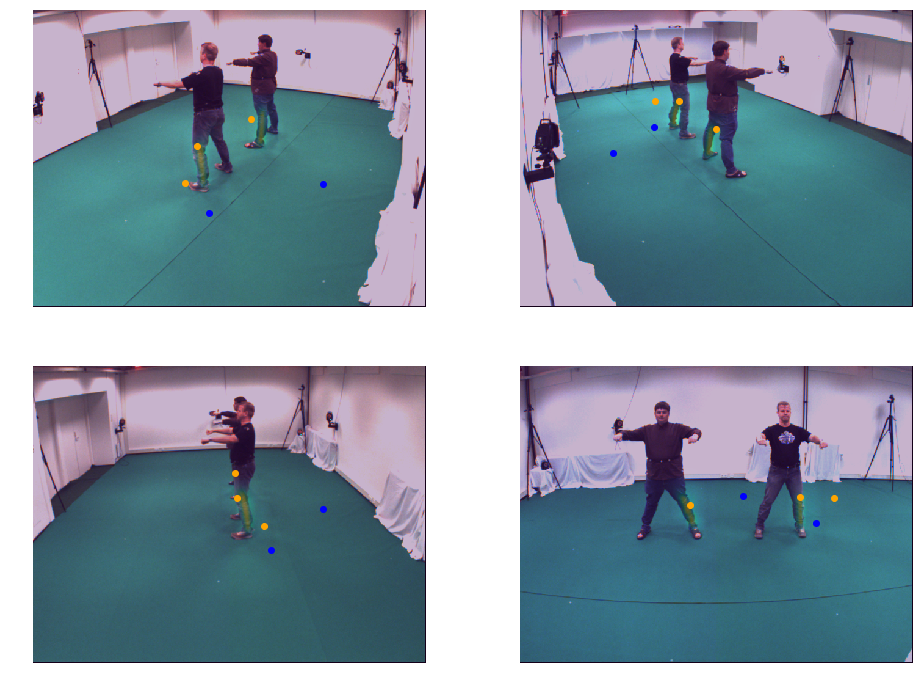

In [7]:
import numpy.linalg as la
from scipy.special import comb

cid = 2
LIMB_ID = 11

#cam = Calib[cid]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure(figsize=(16,12))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

a,b = DEFAULT_LIMB_SEQ[LIMB_ID]
pafA, pafB = DEFAULT_MAP_IDX[LIMB_ID]
length_min, length_max = DEFAULT_SENSIBLE_LIMB_LENGTH[LIMB_ID]

candA3d = Gr.peaks3d_weighted[a]
candB3d = Gr.peaks3d_weighted[b]
nA = len(candA3d)
nB = len(candB3d)

W = np.zeros((nA, nB))

camera_normalization = comb(len(Calib), 2)

for cid, cam in enumerate(Calib):
    im = Im[cid]
    ax = fig.add_subplot(2,2,cid+1)
    ax.imshow(im)
    ax.axis('off')
    
    _start = time()
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    U = pafs[cid,:,:,pafA]
    V = pafs[cid,:,:,pafB]

    h,w,_ = im.shape

    ptsA2d, maskA = gm.reproject_points_to_2d(
        candA3d[:,0:3], rvec, tvec, K, w, h, distCoef=distCoef, binary_mask=True)
    ptsB2d, maskB = gm.reproject_points_to_2d(
        candB3d[:,0:3], rvec, tvec, K, w, h, distCoef=distCoef, binary_mask=True)


    maskA = maskA == 1
    maskB = maskB == 1

    _end = time()
    print('part 1 elapsed:', _end - _start)
    
    for i, (ptA, ptA3d, is_A_on_screen) in enumerate(zip(ptsA2d, candA3d, maskA)):
        if is_A_on_screen:
            ax.scatter(ptA[0], ptA[1], color='orange')

    for j, (ptB, ptB3d, is_B_on_screen) in enumerate(zip(ptsB2d, candB3d, maskB)):
        if is_B_on_screen:
            ax.scatter(ptB[0], ptB[1], color='blue')

    Vec = draw_vector_field(U, V)
    ax.imshow(Vec, alpha=0.3)

    

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    _start = time()
    
    ptA_candidates = []
    ptB_candidates = []
    pair_candidates = []
    
    for i, (ptA, ptA3d, is_A_on_screen) in enumerate(zip(ptsA2d, candA3d, maskA)):
        if not is_A_on_screen:
            continue
        #ptA = np.expand_dims(ptA, axis=0)
        for j, (ptB, ptB3d, is_B_on_screen) in enumerate(zip(ptsB2d, candB3d, maskB)):
            if not is_B_on_screen:
                continue
            distance = la.norm(ptA3d[0:3] - ptB3d[0:3])
            if length_min < distance < length_max:
                #ptB = np.expand_dims(ptB, axis=0)

                ptA_candidates.append(ptA)
                ptB_candidates.append(ptB)
                pair_candidates.append((i, j))
    
    line_int = mvpafs.calculate_line_integral(
        np.array(ptA_candidates), np.array(ptB_candidates), U, V)
    
    print(line_int.shape)
    
                #line_int = mvpafs.calculate_line_integral(ptA, ptB, U, V)
                #w = np.squeeze(line_int) / camera_normalization
                #W[i,j] += w
                
#                 Ax, Ay = np.squeeze(ptA)
#                 Bx, By = np.squeeze(ptB)

#                 if w > 0:
#                     ax.plot([Ax, Bx], [Ay, By], color='green', linewidth=w*10, alpha=0.4)
#                 else:
#                     ax.plot([Ax, Bx], [Ay, By], color='red', linewidth=-w*10, alpha=0.4)
    _end = time()
    print('elapsed', _end - _start)
            
plt.show()

In [8]:
ptA3d[5:]

array([39.21283473, 12.26906467])

## Build graph using pafs

In [9]:
np.max(W)

0.0

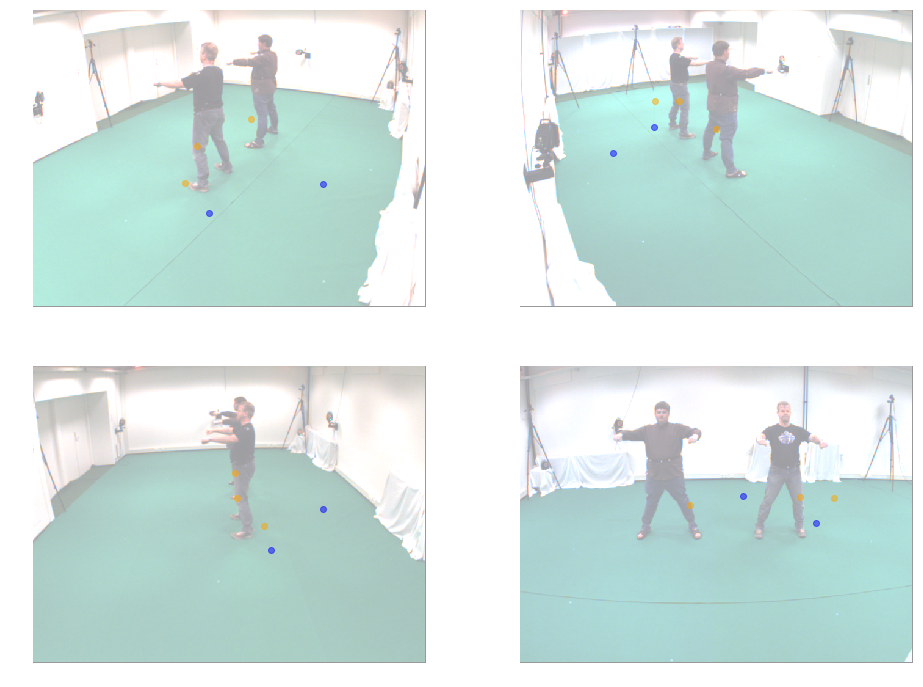

In [10]:
# take some random limb (left elbow -> hand left)
LIMB_ID = 11
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Gr.limbs3d[LIMB_ID]
n,m = W.shape
candA = Gr.peaks3d_weighted[a][:,0:3]
candB = Gr.peaks3d_weighted[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))

#for idx, cam in enumerate(Gr.Calib_undistorted):
for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    
    ptsA2d, maskA = gm.reproject_points_to_2d(candA, rvec, tvec, K, w, h, distCoef=distCoef)
    ptsB2d, maskB = gm.reproject_points_to_2d(candB, rvec, tvec, K, w, h, distCoef=distCoef)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    for _a in maskA[0]:
        for _b in maskB[0]:
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*5, alpha=0.4)
            else:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*5, alpha=0.4)


plt.show()

## Solve the optimization problem

$$
E = \biggr(\sum_{j_1}^{J_1} \sum_{j_2}^{J_2} \lambda(j_1, j_2) \Phi(j_1, j_2) \biggr)
+ \biggr(\sum_{j_1}^{J_1} \sum_{j_2}^{J_1} \iota(j_1, j_2)\Pi(j_1, j_2) \biggr)
+ \biggr(\sum_{j_1}^{J_2} \sum_{j_2}^{J_2} \iota(j_1, j_2)\Pi(j_1, j_2) \biggr)
$$

given the following transitivity conditions:

$$\lambda(a,c) + \lambda(b,c) - 1 \leq \iota(a,b)$$
$$\lambda(a,c) + \iota(a,b) - 1 \leq \lambda(b,c)$$

In [11]:
from ortools.linear_solver import pywraplp as mip


def cluster(points3d, limbs3d, limbSeq, sensible_limb_length, radius=200, max_radius=300):
    assert len(limbs3d) == len(limbSeq)
    assert len(limbs3d) == len(sensible_limb_length)
    
    solver = mip.Solver('SolveAssignmentProblemMIP',
                               mip.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    
    
    Lambda = {}  # inter-class edges
    Lambda_pairs = []
    Iota = {}  # intra-class edges
    Iota_weights = {}
    handled_joints = {}
    Sums = []
    
    TOTAL = 0
    
    for lid, (W, (a,b), (min_length, max_length)) in enumerate(zip(limbs3d, limbSeq, sensible_limb_length)):
        candA = points3d[a]
        candB = points3d[b]
        nA = len(candA)
        nB = len(candB)
        assert nA == W.shape[0]
        assert nB == W.shape[1]
        
        print("QQ", lid)
        
        #TRANSFER = lambda x: np.tanh(x)
        TRANSFER = lambda x: x
        
        
        lm_pairs = []  # TODO do something with this..
        Lambda_pairs.append(lm_pairs)
        io1_pairs = []
        io2_pairs = []
        
        for i in range(nA):
            for j in range(nB):
                distance = la.norm(candA[i,0:3] - candB[j,0:3])
                if min_length < distance < max_length:
                    Lambda[lid,i,j] = solver.BoolVar('lambda%i[%i,%i]' % (lid,i,j))
                    lm_pairs.append((i,j))
        
        is_a_handled = a in handled_joints
        if not is_a_handled:
            for i in range(nA):
                for j in range(nA):
                    if i == j:
                        continue
                    x = la.norm(candA[i,0:3] - candA[j,0:3])
                    if x < max_radius:
                        w = 1/x - 1/radius  # positive when > radius, o/w negative
                        Iota_weights[a,i,j] = w
                        Iota[a,i,j] = solver.BoolVar('iota%i[%i,%i]' % (a,i,j))
                        io1_pairs.append((i,j))
            handled_joints[a] = io1_pairs
        
        is_b_handled = b in handled_joints
        if not is_b_handled:
            for i in range(nB):
                for j in range(nB):
                    if i == j:
                        continue
                    x = la.norm(candB[i,0:3] - candB[j,0:3])
                    if x < max_radius:
                        #w = 1/x - 1/radius  # positive when > radius, o/w negative
                        w = radius - x
                        Iota_weights[b,i,j] = w
                        Iota[b,i,j] = solver.BoolVar('iota%i[%i,%i]' % (b,i,j))
                        io2_pairs.append((i,j))
            handled_joints[b] = io2_pairs

                
        for i in range(nA):
            for j in range(nA):
                for k in range(nB):
                    q1 = (lid, i, k) in Lambda
                    q2 = (lid, j, k) in Lambda
                    q3 = (a, i, j) in Iota
                    
                    if q1 and q2 and q3:
                        solver.Add(Lambda[lid, i, k] + Lambda[lid, j, k] - 1 <= Iota[a, i, j])
                        solver.Add(Lambda[lid, i, k] + Iota[a, i, j] - 1 <= Lambda[lid, j, k])
                    
        
        for i in range(nB):
            for j in range(nB):
                for k in range(nA):
                    q1 = (lid, k, i) in Lambda
                    q2 = (lid, k, j) in Lambda
                    q3 = (b, i, j) in Iota
                    
                    if q1 and q2 and q3:
                        solver.Add(Lambda[lid, k, i] + Lambda[lid, k, j] - 1 <= Iota[b, i, j])
                        solver.Add(Lambda[lid, k, i] + Iota[b, i, j] - 1 <= Lambda[lid, k, j])
        
        sum_lambda = solver.Sum(
            Lambda[lid, i,j] * TRANSFER(W[i,j]) for i,j in lm_pairs)
        Sums.append(sum_lambda)
        
        if not is_a_handled:
            sum_A = solver.Sum(
                Iota[a,i,j] * TRANSFER(Iota_weights[a,i,j]) for i,j in io1_pairs)
            Sums.append(sum_A)
        
        if not is_b_handled:
            sum_B = solver.Sum(
                Iota[b,i,j] * TRANSFER(Iota_weights[b,i,j]) for i,j in io2_pairs)
            Sums.append(sum_B)

        
    
    print('prepare to solve')
    solver.Maximize(sum(Sums))
    solver.Solve()
    print("Time = ", solver.WallTime(), " ms")
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # get graph from the edges
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    L_graph = []
    J_graph = {}
    
    for lid, ((a,b), lm_pairs) in enumerate(zip(limbSeq, Lambda_pairs)):
        
        W = limbs3d[lid]
        
        io1_pairs = handled_joints[a]
        io2_pairs = handled_joints[b]
        
        l_graph = []
        L_graph.append(l_graph)
        for i,j in lm_pairs:
            if Lambda[lid, i, j].solution_value() > 0:
                l_graph.append((i,j, W[i,j]))
        
        if a not in J_graph:
            pairs = []
            J_graph[a] = pairs
            for i,j in io1_pairs:
                if Iota[a,i,j].solution_value() > 0:
                    pairs.append((i,j, Iota_weights[a,i,j]))
        
        if b not in J_graph:
            pairs = []
            J_graph[b] = pairs
            for i,j in io2_pairs:
                if Iota[b,i,j].solution_value() > 0:
                    pairs.append((i,j,Iota_weights[b,i,j]))
            
    
    return L_graph, J_graph
    


Points3d = Gr.peaks3d_weighted
Limbs3d = Gr.limbs3d


print('ww')
L, J = cluster(Points3d, Limbs3d, DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH)


print('qq')

ww
QQ 0
QQ 1
QQ 2
QQ 3
QQ 4
QQ 5
QQ 6
QQ 7
QQ 8
QQ 9
QQ 10
QQ 11
QQ 12
QQ 13
QQ 14
QQ 15
QQ 16
QQ 17
QQ 18
prepare to solve
Time =  23  ms
qq


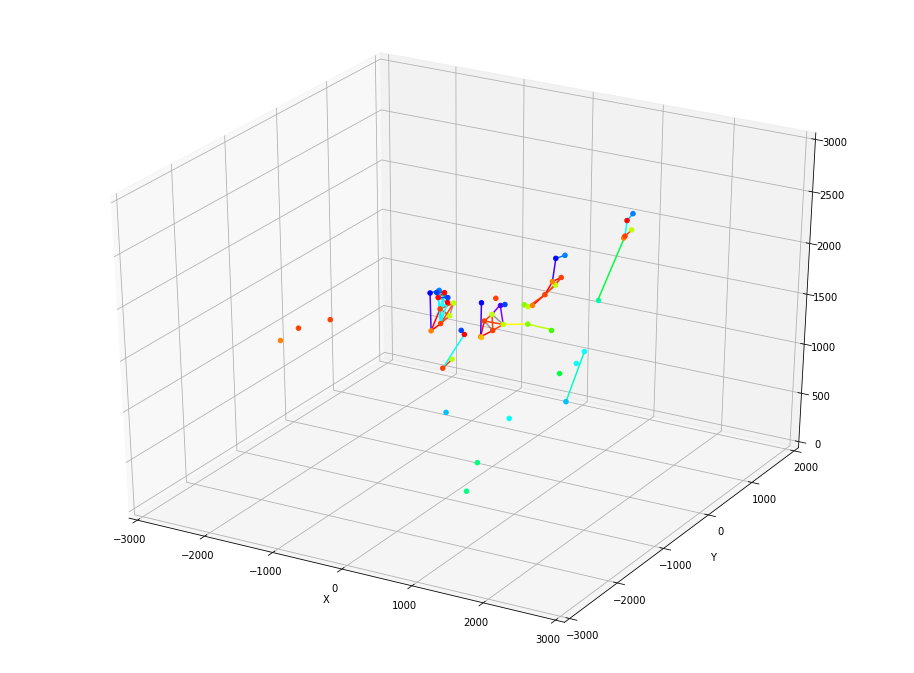

In [12]:
COLORS = cs.lincolor(25)/255
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-3000, 3000])
ax.set_ylim([-3000, 2000])
ax.set_zlim([0, 3000])
ax.set_xlabel('X')
ax.set_ylabel('Y')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Points3d = Gr.peaks3d_weighted

is_joint_plotted = set()

for lid, (a,b) in enumerate(DEFAULT_LIMB_SEQ):
    for jid in [a,b]:
        if not jid in is_joint_plotted:
            is_joint_plotted.add(jid)
            X = Points3d[jid][:,0]
            Y = Points3d[jid][:,1]
            Z = Points3d[jid][:,2]
            ax.scatter(X, Y, Z, color=COLORS[jid], alpha=1)
        
            for (i, j, _) in J[jid]:
                x1 = Points3d[jid][i,0]
                x2 = Points3d[jid][j,0]
                y1 = Points3d[jid][i,1]
                y2 = Points3d[jid][j,1]
                z1 = Points3d[jid][i,2]
                z2 = Points3d[jid][j,2]
                ax.plot([x1,x2], [y1,y2], [z1,z2], color='black',
                       alpha=0.2)
    
    for i, j, _ in L[lid]:
        x1 = Points3d[a][i,0]
        x2 = Points3d[b][j,0]
        y1 = Points3d[a][i,1]
        y2 = Points3d[b][j,1]
        z1 = Points3d[a][i,2]
        z2 = Points3d[b][j,2]
        ax.plot([x1,x2], [y1,y2], [z1,z2], color=COLORS[lid],
               alpha=1)
        

plt.show()

3


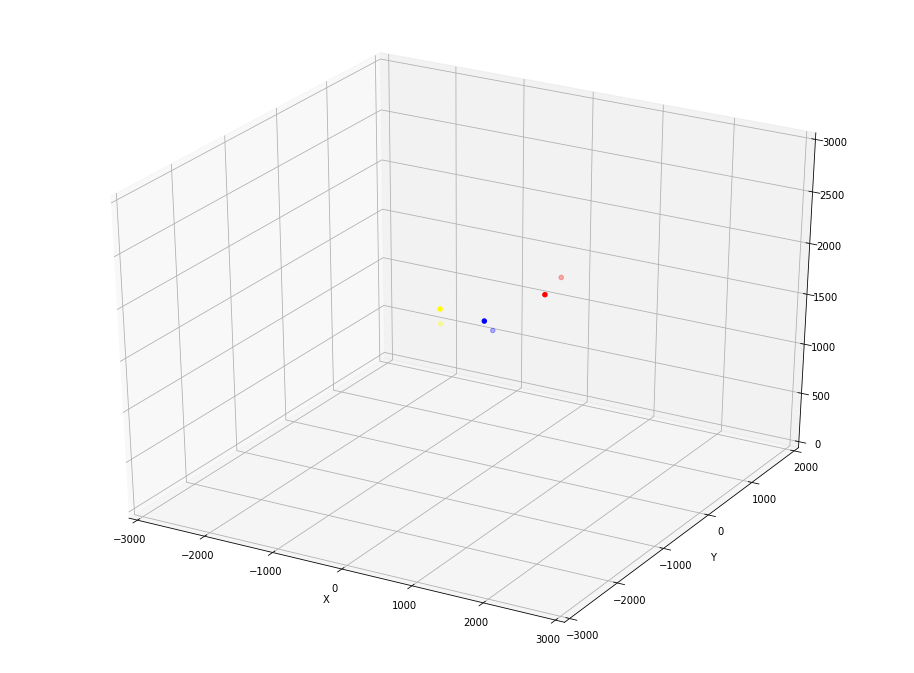

In [13]:
from graphviz import Graph
import networkx as nx

#g = Graph('G')

G = nx.Graph()

idx = 1


for a,b,w in J[idx]:
    G.add_edge(a, b)
    #g.edge(str(a), str(b))
    

#g.render('~/round-table.gv', view=True) 

demo = []

for g in nx.connected_component_subgraphs(G):
    demo.append(list(g.nodes))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-3000, 3000])
ax.set_ylim([-3000, 2000])
ax.set_zlim([0, 3000])
ax.set_xlabel('X')
ax.set_ylabel('Y')

points3d = Points3d[idx]

COLOR = ['red', 'blue', 'yellow', 'green', 'teal', 'black', 'cornflowerblue']

print(len(demo))
for i, subg in enumerate(demo):
    pts3d = points3d[subg]
    x = pts3d[:,0]
    y = pts3d[:,1]
    z = pts3d[:,2]
    ax.scatter(x,y,z,color=COLOR[i])
    


    
plt.show()



In [14]:
# G = nx.Graph()

# idx = 1


# for a,b,w in J[idx]:
#     G.add_edge(a, b)
#     print(w)

class FlatGraph:
    
    def __init__(self, J):
        n_joints = len(J)
        
        J_lookup = {}
        J_reverse_lookup = {}
        
        counter = 0
        for jid in range(n_joints):
            W_intra = np.array(J[jid])
            if W_intra.shape[0] == 0:
                continue
            for x in np.unique(W_intra[:,0]):
                if not (jid, x) in J_lookup:
                    J_lookup[jid, int(x)] = counter
                    J_reverse_lookup[counter] = (jid, int(x))
                    counter += 1
            
            for x in np.unique(W_intra[:,1]):
                if not (jid, int(x)) in J_lookup:
                    J_lookup[jid, x] = counter
                    J_reverse_lookup[counter] = (jid, int(x))
                    counter += 1
        
        self.J_lookup = J_lookup
        self.J_reverse_lookup = J_reverse_lookup
    
    def get_unique_id(self, jid, i):
        return self.J_lookup[jid, i]
    
    def get_joint_and_id(self, pos):
        return self.J_reverse_lookup[pos]
        
        

def extract(L, J, limbSeq):
    
    opti = FlatGraph(J)

    G = nx.Graph()
    
    for lid, (inter_pairs, (a,b)) in enumerate(zip(L, limbSeq)):
        for i,j,w in inter_pairs:
            pos_i = opti.get_unique_id(a, i)
            pos_j = opti.get_unique_id(b, j)
        



extract(L, J, DEFAULT_LIMB_SEQ)


KeyError: (2, 0)

In [ ]:
a = np.array([1.3, 0])
b = np.array([1, 0])


a @ b